# Between-group differences in error rate probabilities

We have distinct but related sets of questions about error rates.
1. What properties of subjects cause them to make more/fewer errors?
2. What properties of positions cause subjects to make more/fewer errors?
3. What properties of a particular piece in a position cause subjects to make more/fewer errors?

This notebook covers analyses for (1) above.

## Notebook setup

In [1]:
# Standard libraries
import os
import sys

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from jupyterthemes import jtplot

# Numerical libraries
import numpy as np
import pandas as pd
import patsy as pt
import pymc3 as pm
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
from theano import tensor as T

# Internal libraries
sys.path.append('../../src')

# import lib.reconstruction.errors as errs
from lib.reconstruction.errors import get_errors_per_location
from lib.reconstruction.neighbors import FilterByOccupied
from lib.reconstruction.neighbors import get_adjacency, get_adjacency_per_location

from lib.reconstruction.bayes.poisson import build_poisson_model

In [2]:
# Notebook configuration
pd.set_option('display.max_columns', 40)

sns.set_style('white')
sns.set_context('paper')

colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)

%matplotlib inline

## Load data

In [3]:
tidy = pd.read_csv('../../etc/reconstruction/tidy_data.csv', index_col=0)

tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

vals = ['Black Position', 'White Position', 
        'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', 
                             values=vals, 
                             aggfunc=lambda x: x.unique()[0])[vals]

### Data preprocessing

In [6]:
# Compute the adjacency of each location

adjacencies = board_set.apply(get_adjacency_per_location, axis=1)

adjacency_column_names = ['adjacency_all', 
                          'adjacency_same', 
                          'adjacency_opposite']

adjacency_df = pd.DataFrame(adjacencies.tolist(), 
                            index=board_set.index, 
                            columns=adjacency_column_names)

In [ ]:
def get_occupied_mask(row):
    """Return indicators for whether a piece was at a location"""
    bp = np.stack([int(i) for i in row['Black Position']])
    wp = np.stack([int(i) for i in row['White Position']])
    p = bp + wp
    return p.tolist()

def get_condition_mask(condition):
    """Return convenience indicators for condition"""
    return [condition, ] * 36

for error_type in range(1, 4):
    tidy[f'errors_{error_type}'] = tidy.apply(
        lambda x: get_errors_per_location(x, str(error_type)), axis=1)

# Compute occupancy and condition indicators 
# for each location on each trial
tidy['occupied'] = tidy.apply(get_occupied_mask, axis=1)
tidy['condition_mask'] = tidy['Condition'].map(get_condition_mask)

# For convenience, 
# pull per-location adjacency statistics for each trial
# into the per-trial dataframe
tidy['adjacency_same'] = tidy['Position ID'].map(adjacency_df['adjacency_same'])
tidy['adjacency_opposite'] = tidy['Position ID'].map(adjacency_df['adjacency_opposite'])

# Convert the subject UID to an integer index
subject_ids = tidy['Subject ID'].unique()
subject_index = np.arange(len(subject_ids))
subject_index_map = dict(zip(subject_ids, subject_index))

tidy['subject_idx'] = tidy['Subject ID'].map(subject_index_map)

In [8]:
def get_error_rates(df):
    """(DEPRECATED?) Return type 2 average error rates in a vector"""
    return np.stack(df['errors_2'], axis=1).mean(axis=1)

# Per-position mean error rates (over subjects)
g = tidy.groupby('Position ID')
board_set['errors'] = g.apply(get_error_rates)

# Get a dummy array of location indices for convenience
board_set['location_idx'] = np.tile(np.arange(36, dtype=np.uint8), [len(board_set), 1]).tolist()

# Get distances to center as a dummy field
# (same for all positions!)
blank_board = np.zeros((4, 9))
center = (blank_board.shape[0] / 2 - .5, blank_board.shape[1] / 2 - .5)

distances = np.sqrt(((np.argwhere(blank_board == 0) - center) ** 2).sum(axis=1))
board_set['distance_to_center'] = np.tile(distances, [len(board_set), 1]).tolist()

In [12]:
# Construct filter functions
occupied_error_filter = FilterByOccupied('errors')
occupied_same_filter = FilterByOccupied('adjacency_same')
occupied_opposite_filter = FilterByOccupied('adjacency_opposite')
occupied_distances_filter = FilterByOccupied('distance_to_center')

# Create a dataframe with both board set metadata and adjacency measures
sum_df = pd.concat([board_set, adjacency_df], axis=1)

# Apparently there were some null outputs here? 
# Don't recall why...
sum_df = sum_df.loc[pd.notnull(sum_df['errors'])]

# For each board, filter the measurements to discard unoccupied locations
sum_df['occupied_errors'] = sum_df.apply(occupied_error_filter, axis=1)
sum_df['occupied_adjacency_same'] = sum_df.apply(occupied_same_filter, axis=1)
sum_df['occupied_adjacency_opposite'] = sum_df.apply(occupied_opposite_filter, axis=1)
sum_df['occupied_distance_to_center'] = sum_df.apply(occupied_distances_filter, axis=1)

In [17]:
# Set up data for use with PyMC3
# New dataframe should have *locations* in individual rows

def expand_indicators(x):
    return np.stack([int(x), ] * 36)

# Extract exogenous variables
x_same = np.concatenate(tidy['adjacency_same'].values)
x_opposite = np.concatenate(tidy['adjacency_opposite'].values)
x_occupied = np.concatenate(tidy['occupied'].values)
x_condition_mask = np.concatenate(tidy['condition_mask'].values)

x_subject = np.concatenate(tidy['subject_idx'].map(expand_indicators)
x_position_type = np.concatenate(tidy['Is Real'].map(expand_indicators)
x_position_id = np.concatenate(tidy['Position ID'].map(expand_indicators)

# Extract endogenous variables
y1 = np.concatenate(tidy['errors_1'].values)
y2 = np.concatenate(tidy['errors_2'].values)
y3 = np.concatenate(tidy['errors_3'].values)

columns = ['subject', 'condition_mask', 'occupied', 
           'same', 'opposite', 
           'position_type', 'position_id',
           'errors_1', 'errors_2', 'errors_3']
                               
df_data = np.stack((x_subject, x_condition_mask, x_occupied, 
                    x_same, x_opposite, 
                    x_position_type, x_position_id,
                    y1, y2, y3)).T

bayes_model_df = pd.DataFrame(data=df_data, columns=columns)

# Force pandas to use integers
# Why doesn't it by default? Who knows, but it's dumb.
for c in bayse_model_df.columns:
    bayes_model_df[c] = bayes_model_df[c].astype(int)

bayes_model_df['condition_indicator'] = bayes_model_df['condition_mask'].map(
    {'Trained': 1, 'Untrained': 0}).astype(int)

In [ ]:
# Set up condition and position type indicators
trained_sel = bayes_model_df['condition_mask'] == 'Trained'
untrained_sel = bayes_model_df['condition_mask'] == 'Untrained'
natural_sel  = bayes_model_df['position_type'] == 1
synthetic_sel = bayes_model_df['position_type'] == 0

In [20]:
# Convert subject indices for columnar format
# Eg, indexes start from 0 for both trained/untrained groups

bayes_model_df.loc[untrained_sel, 'subject'] = bayes_model_df.loc[untrained_sel, 'subject'] % 19

# But still cache a unique indicator for each subject
bayes_model_df['usubject'] = bayes_model_df['subject'] 
bayes_model_df += bayes_model_df['condition_indicator'] * 19

# Same for real/fake positions
natural_ids = bayes_model_df.loc[natural_sel, 'position_id'].astype(int)
bayes_model_df.loc[natural_sel, 'position_id'] = natural_ids - natural_ids.min()

# Get an integer indicator for the *type* of error that was made
# Where a 0 indicates no error
error_columns = ['errors_1', 'errors_2', 'errors_3']
bayes_model_df['has_error'] = bayes_model_df[error_columns].astype(int).sum(axis=1)

error_sel = bayes_model_df['has_error'] == 1

error_values = bayes_model_df.loc[error_sel, error_columns].values
error_types = np.argmax(error_values, axis=1) + 1

bayes_model_df['error_type'] = 0
bayes_model_df.loc[error_sel, 'error_type'] = error_types

,subject,condition_mask,occupied,same,opposite,position_type,position_id,errors_1,errors_2,errors_3,condition_indicator
0,0,Trained,1,0.0,0.3333333333333333,1,25,0,0,0,1
1,0,Trained,0,0.0,0.0,1,25,0,0,0,1
2,0,Trained,0,0.0,0.0,1,25,0,0,0,1
3,0,Trained,0,0.0,0.0,1,25,0,0,0,1
4,0,Trained,0,0.0,0.0,1,25,0,0,0,1


In [26]:
# Create a pivot table, per subject, for locations with errors
has_error_df = bayes_model_df.loc[error_sel]
bayes_subject_piv = has_error_df.pivot_table(index='usubject', 
                                             columns='error_type',
                                             values='position_id',
                                             aggfunc=len)

# Total counts
bayes_subject_piv['n'] = bayes_subject_piv[[1, 2, 3]].sum(axis=1)

# Group indicator
bayes_subject_piv['group'] = has_error_df.pivot_table(index='usubject',
                                                      values='condition_indicator',
                                                      aggfunc=lambda x: np.unique(x)[0])

# Melt it back down to get a table of per-error-type count data
# including group indicators and totals
melted_df = pd.melt(bayes_subject_piv, 
                    id_vars=['group'], 
                    value_vars=[1, 2, 3], 
                    value_name='error_count')

error_type,1,2,3,n,group
usubject,,,,,
0,126,280,137,543,0
1,96,191,52,339,0
2,214,398,182,794,0
3,95,211,60,366,0
4,170,375,121,666,0
5,116,298,83,497,0
6,98,395,68,561,0
7,142,225,105,472,0
8,136,415,98,649,0


In [31]:
# Finally (finally!) use count df and patsy formula 
# to generate regression indicator endogenous data
# and count exogenous data

formula = 'error_count ~ error_type * group'

endogenous_df, exogenous_df = pt.dmatrices(formula, melted_df, 
                                           return_type='dataframe', 
                                           NA_action='raise')

In [152]:
with pm.Model() as poisson_model:
    sds = []
    coeffs = []
    
    b0 = pm.Normal('intercept', mu=0, sd=10)
    coeffs.append(b0)

    for col in mx_ex.columns[1:]:
        c = col.replace(':', '_')
        sd = pm.HalfStudentT(f'sd_{c}', nu=2, lam=.001)
        b = pm.Normal(f'b_{c}', mu=0, tau=1/sd**2)
        
        sds.append(sd)
        coeffs.append(b)
    
    b6 = pm.Deterministic('b_error_type[T.1]_group', 
                          -coeffs[4] - coeffs[5])
    
    theta = T.dot(mx_ex.values, T.stack(coeffs))
    
    y = pm.Poisson('y', mu=T.exp(theta), observed=mx_en['error_count'].values)

In [210]:
coeffs

[intercept,
 b_error_type[T.2],
 b_error_type[T.3],
 b_group,
 b_error_type[T.2]_group,
 b_error_type[T.3]_group]

intercept -3.2215236261987186
sd_error_type[T.2]_log__ -0.9547712690287238
b_error_type[T.2] -4.3728161726957415
sd_error_type[T.3]_log__ -0.9547712690287238
b_error_type[T.3] -4.3728161726957415
sd_group_log__ -0.9547712690287238
b_group -4.3728161726957415
sd_error_type[T.2]_group_log__ -0.9547712690287238
b_error_type[T.2]_group -4.3728161726957415
sd_error_type[T.3]_group_log__ -0.9547712690287238
b_error_type[T.3]_group -4.3728161726957415
y -101482.14998462633


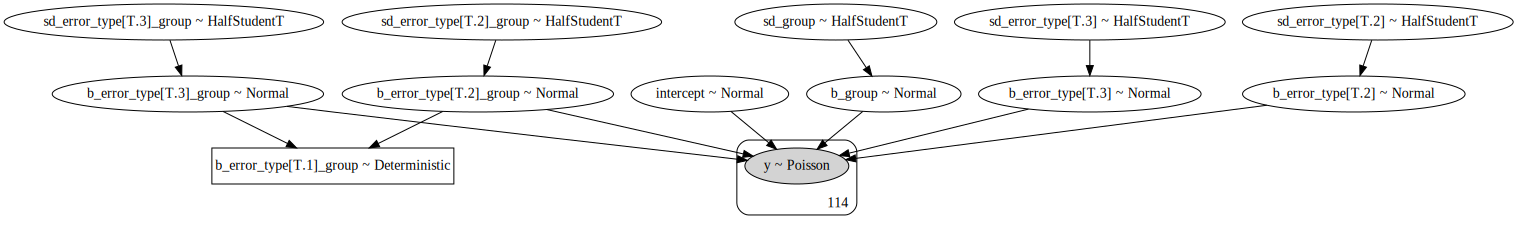

In [217]:
for RV in poisson_model.basic_RVs:
    print(RV.name, RV.logp(poisson_model.test_point))
    
pm.model_to_graphviz(poisson_model)

In [212]:
with poisson_model:
    poisson_trace = pm.sample(6000, tune=2000, cores=4, 
                              nuts_kwargs={'target_accept': .99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_error_type[T.3]_group, sd_error_type[T.3]_group, b_error_type[T.2]_group, sd_error_type[T.2]_group, b_group, sd_group, b_error_type[T.3], sd_error_type[T.3], b_error_type[T.2], sd_error_type[T.2], intercept]
Sampling 4 chains: 100%|██████████| 32000/32000 [01:10<00:00, 456.20draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


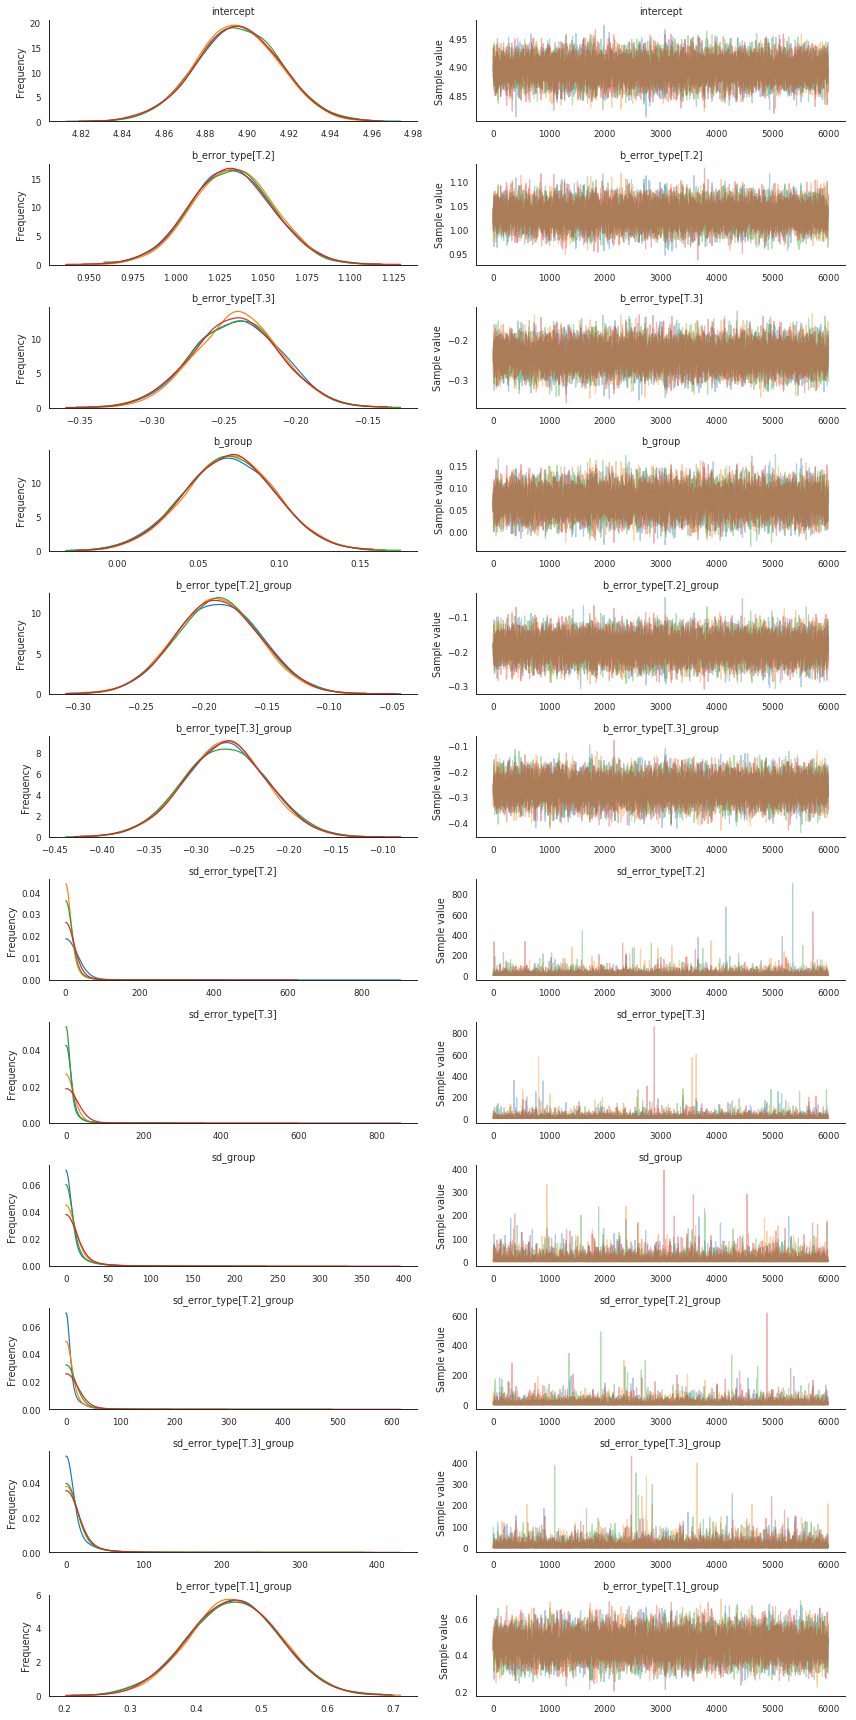

In [214]:
pm.traceplot(poisson_trace)
sns.despine();

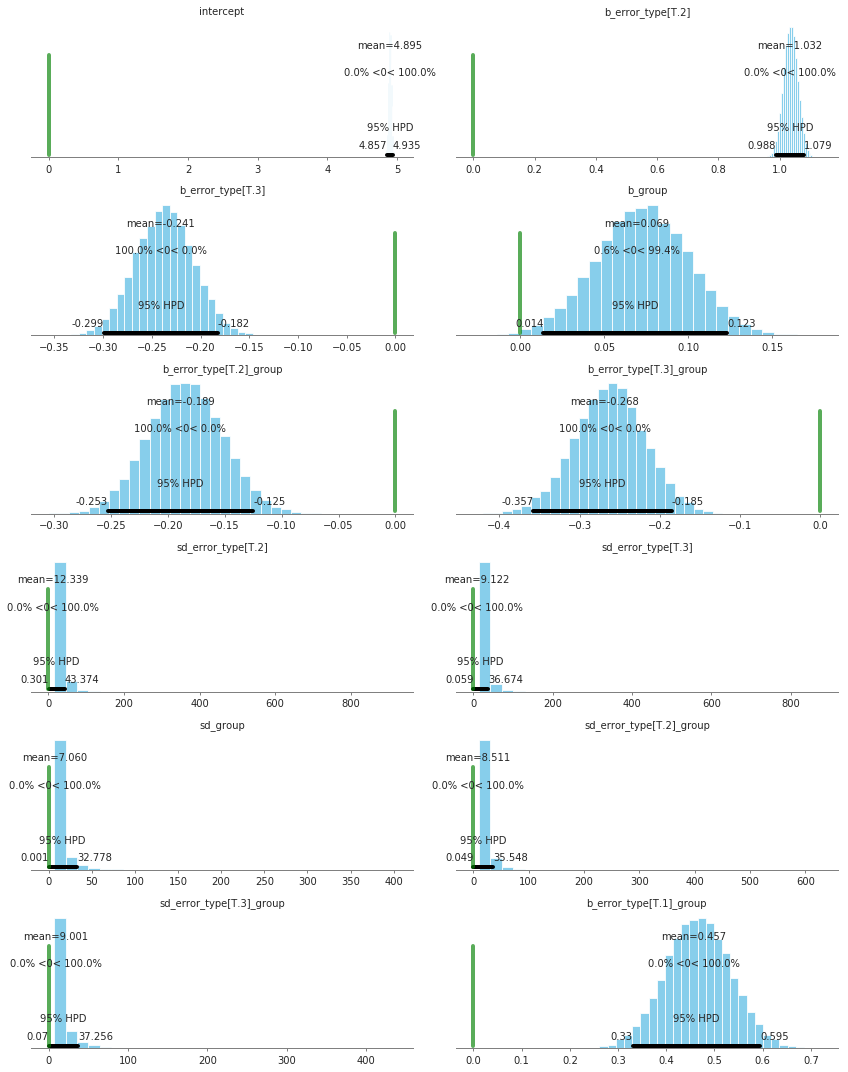

In [215]:
pm.plot_posterior(poisson_trace,
                  ref_val=0,
                  color='#87ceeb');

In [216]:
pm.summary(poisson_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,4.895328,0.019831,0.000200,4.857067,4.934814,8292.236549,1.000285
b_error_type[T.2],1.031803,0.023084,0.000236,0.988482,1.079054,8714.015127,1.000335
b_error_type[T.3],-0.241081,0.029953,0.000313,-0.299438,-0.182209,9971.483514,1.000205
b_group,0.069228,0.027816,0.000293,0.013679,0.123183,8548.232095,1.000205
b_error_type[T.2]_group,-0.188846,0.032839,0.000324,-0.252756,-0.124674,9264.195012,1.000145
b_error_type[T.3]_group,-0.268456,0.043794,0.000472,-0.357500,-0.185099,9931.134786,1.000024
sd_error_type[T.2],12.338917,21.153391,0.151327,0.300642,43.373744,16905.720670,0.999924
sd_error_type[T.3],9.121941,19.869371,0.149125,0.058571,36.673743,16615.126311,0.999943
sd_group,7.059858,15.184376,0.113260,0.001072,32.777681,20558.426067,1.000007
sd_error_type[T.2]_group,8.510828,16.811011,0.114025,0.048959,35.547557,19246.511007,0.999999
